# Chapter: Finding Groups in Process Data: Clustering & Mixture Modeling

# Topic: Process Monitoring via GMM 

In [12]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          Process Monitoring of Etch data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [13]:
# import required packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

In [14]:
# fetch data
import scipy.io

matlab_data = scipy.io.loadmat('MACHINE_Data.mat', struct_as_record = False)
Etch_data = matlab_data['LAMDATA']
calibration_dataAll = Etch_data[0,0].calibration # calibration_dataAll[i,0] corresponds to a 2D data from ith batch where columns correspond to different variables 

variable_names = Etch_data[0,0].variables

In [15]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          perform Multiway PCA
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [16]:
# generate unfolded data matrix
n_vars = variable_names.size - 2 # first 2 columns are not process variables
n_samples = 85 # following the work of He et al.

unfolded_dataMatrix = np.empty((1,n_vars*n_samples))
for expt in range(calibration_dataAll.size):
    calibration_expt = calibration_dataAll[expt,0][5:90,2:] # removing first 5 measurements as done in He et al.
    
    if calibration_expt.shape[0] < 85:
        continue
    
    unfolded_row = np.ravel(calibration_expt, order='F')[np.newaxis,:]
    unfolded_dataMatrix = np.vstack((unfolded_dataMatrix, unfolded_row))

unfolded_dataMatrix = unfolded_dataMatrix[1:,:]

In [17]:
# scale data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_train_normal = scaler.fit_transform(unfolded_dataMatrix)

In [18]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components = 3) # following the work of He et al.
score_train = pca.fit_transform(data_train_normal)

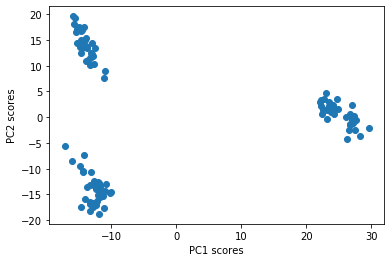

In [19]:
# visualize in 2D
plt.figure()
plt.scatter(score_train[:,0],score_train[:,1])
plt.xlabel('PC1 scores')
plt.ylabel('PC2 scores')
plt.show()

In [20]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          GMM on PCA scores
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

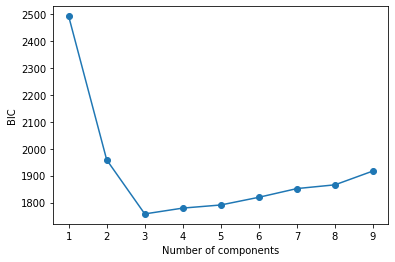

In [21]:
# finding # of components via BIC 
BICs = []
lowestBIC = np.inf
for n_cluster in range(1, 10):
    gmm = GaussianMixture(n_components = n_cluster, random_state = 100)
    gmm.fit(score_train)
    BIC = gmm.bic(score_train)
    BICs.append(BIC)
    
    if BIC < lowestBIC:
        optimal_n_cluster = n_cluster 
        lowestBIC = BIC

plt.figure()
plt.plot(range(1,10), BICs, marker='o')
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.show()

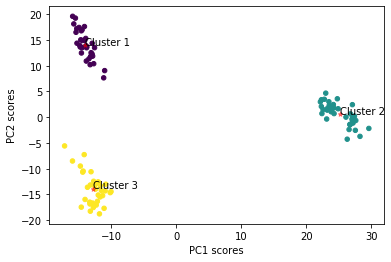

In [22]:
# fit GMM model to metal-etch data
gmm = GaussianMixture(n_components = optimal_n_cluster, random_state = 100)
cluster_label = gmm.fit_predict(score_train)

plt.figure()
plt.scatter(score_train[:, 0], score_train[:, 1], c = cluster_label, s=20, cmap='viridis')
plt.xlabel('PC1 scores')
plt.ylabel('PC2 scores')

cluster_centers = gmm.means_
cluster_plot_labels = ['Cluster ' + str(i+1) for i in range(optimal_n_cluster)]
for i in range(optimal_n_cluster):
    plt.scatter(cluster_centers[i, 0], cluster_centers[i, 1], c='red', s=20, marker = '*', alpha=0.5)
    plt.annotate(cluster_plot_labels[i], (cluster_centers[i,0], cluster_centers[i,1]))

plt.show()

In [23]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          Fault detection metric for training data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [24]:
# global mahalonobis distance metric
Dglobal_train = np.zeros((score_train.shape[0],))

for i in range(score_train.shape[0]):
    x = score_train[i,:,np.newaxis]
    probs = gmm.predict_proba(x.T)
    
    for component in range(3):
        Dlocal =  np.dot(np.dot((x-gmm.means_[component,:,np.newaxis]).T,np.linalg.inv(gmm.covariances_[component,:])),(x-gmm.means_[component,:,np.newaxis]))
        Dglobal_train[i] =  Dglobal_train[i] + probs[0,component]*Dlocal

In [25]:
# Dglobal control limit
N = score_train.shape[0]
r = 3

alpha = 0.05 # 95% control limit
Dglobal_CL = r*(N**2-1)*scipy.stats.f.ppf(1-alpha,r,N-r)/(N*(N-r))

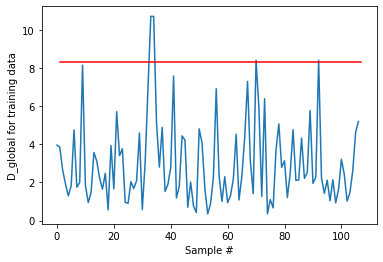

In [26]:
# Dglobal plot with CL
plt.figure()
plt.plot(Dglobal_train)
plt.plot([1,len(Dglobal_train)],[Dglobal_CL, Dglobal_CL], color='red')
plt.xlabel('Sample #')
plt.ylabel('D_global for training data')
plt.show()

In [27]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          test data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [28]:
# fetch test data and unfold
test_dataAll = Etch_data[0,0].test

unfolded_TestdataMatrix = np.empty((1,n_vars*n_samples))
for expt in range(test_dataAll.size):
    test_expt = test_dataAll[expt,0][5:90,2:]
    
    if test_expt.shape[0] < 85:
        continue
    
    unfolded_row = np.ravel(test_expt, order='F')[np.newaxis,:]
    unfolded_TestdataMatrix = np.vstack((unfolded_TestdataMatrix, unfolded_row))

unfolded_TestdataMatrix = unfolded_TestdataMatrix[1:,:]

In [29]:
# PCA on fault data
data_test_normal = scaler.transform(unfolded_TestdataMatrix)
score_test = pca.transform(data_test_normal)

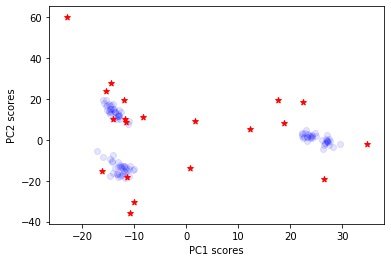

In [30]:
# visualize in 2D (both test and calibration data)
plt.figure()
plt.scatter(score_train[:,0],score_train[:,1], c='blue', alpha=0.1)
plt.scatter(score_test[:,0],score_test[:,1], c='red', marker = '*')
plt.xlabel('PC1 scores')
plt.ylabel('PC2 scores')
plt.show()

In [31]:
# compute Dglobal_test
Dglobal_test = np.zeros((score_test.shape[0],))

for i in range(score_test.shape[0]):
    x = score_test[i,:,np.newaxis]
    probs = gmm.predict_proba(x.T)
    
    for component in range(3):
        Dlocal =  np.dot(np.dot((x-gmm.means_[component,:,np.newaxis]).T,np.linalg.inv(gmm.covariances_[component,:])),(x-gmm.means_[component,:,np.newaxis]))
        Dglobal_test[i] =  Dglobal_test[i] + probs[0,component]*Dlocal


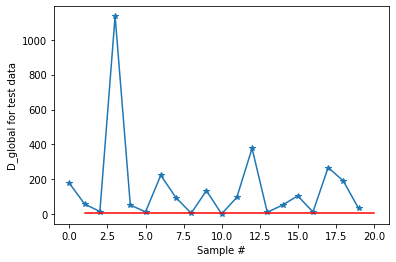

Number of faults identified:  18  out of  20


In [32]:
#%% Dglobal plot with CL
plt.figure()
plt.plot(Dglobal_test, marker = '*')
plt.plot([1,len(Dglobal_test)],[Dglobal_CL,Dglobal_CL], color='red')
plt.xlabel('Sample #')
plt.ylabel('D_global for test data')
plt.show()

print('Number of faults identified: ', np.sum(Dglobal_test > Dglobal_CL), ' out of ', len(Dglobal_test))